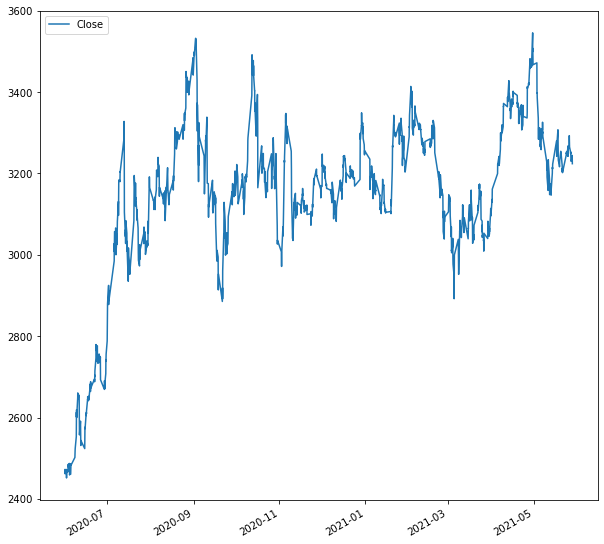

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout, BatchNormalization

%matplotlib inline  


data=yf.download('AMZN',start='2020-06-01', interval='1h',  end='2021-06-01',progress=False)[['Close']]
data.head()
 
data.plot(figsize=(10,10))

In [10]:
cl = data.Close.astype('float32')
train = cl[0:int(len(cl)*0.80)]
scl = MinMaxScaler()
#Scale the data
scl.fit(train.values.reshape(-1,1))
cl =scl.transform(cl.values.reshape(-1,1))
#Create a function to process the data into lb observations look back slices
# and create the train test dataset (90-10)
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)


lb=10
X,y = processData(cl,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

1571 10
175 10
1571
175


In [11]:
#Build the model
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test),shuffle=False)

model.summary() 

Train on 1571 samples, validate on 175 samples
Epoch 1/50
1571/1571 [==============================] - 1s 908us/step - loss: 0.0067 - val_loss: 0.0063
Epoch 2/50
1571/1571 [==============================] - 1s 644us/step - loss: 0.0042 - val_loss: 0.0034
Epoch 3/50
1571/1571 [==============================] - 1s 586us/step - loss: 0.0022 - val_loss: 0.0031
Epoch 4/50
1571/1571 [==============================] - 1s 590us/step - loss: 0.0023 - val_loss: 0.0033
Epoch 5/50
1571/1571 [==============================] - 1s 597us/step - loss: 0.0023 - val_loss: 0.0035
Epoch 6/50
1571/1571 [==============================] - 1s 593us/step - loss: 0.0023 - val_loss: 0.0035
Epoch 7/50
1571/1571 [==============================] - 1s 642us/step - loss: 0.0022 - val_loss: 0.0035
Epoch 8/50
1571/1571 [==============================] - 1s 599us/step - loss: 0.0021 - val_loss: 0.0036
Epoch 9/50
1571/1571 [==============================] - 1s 596us/step - loss: 0.0021 - val_loss: 0.0035
Epoch 10/50
1571/

Text(0.5, 1.0, 'Train Dataset')

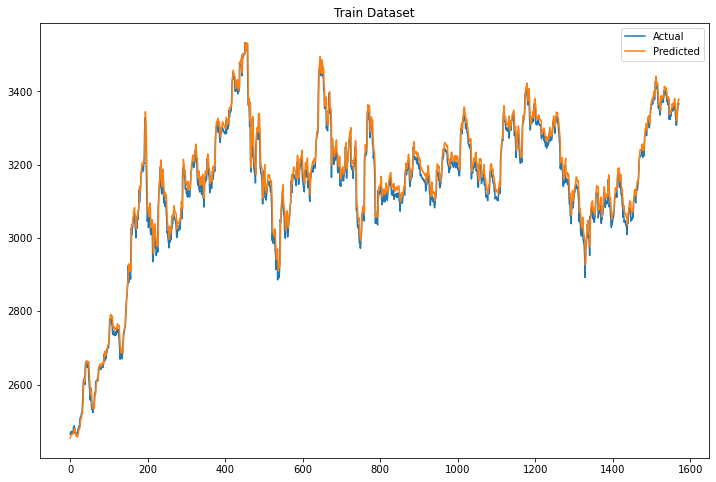

In [12]:
#Train
plt.figure(figsize=(12,8))

Xt = model.predict(X_train)
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")

Text(0.5, 1.0, 'Test Dataset')

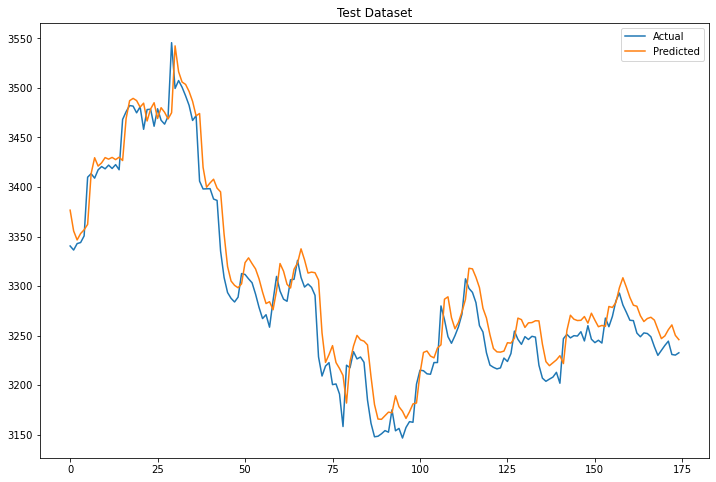

In [13]:
#Test
plt.figure(figsize=(12,8))
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Test Dataset")

Text(0.5, 1.0, 'Test Dataset 250 Obs Ahead')

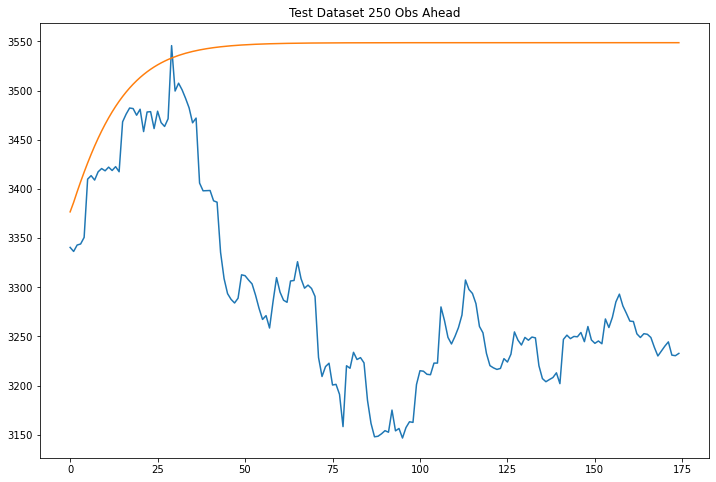

In [14]:
def processData(data,lb):
    X= []
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
    return np.array(X)

# create the x_test_dummy
cl2 =cl.copy()
pred = []
for i in range(X_test.shape[0]):
    cl2[int(X.shape[0]*0.90)+i+lb] = model.predict(X_test)[i]
    pred.extend(model.predict(X_test)[i])
    X = processData(cl2,lb)
    X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))



prediction = scl.inverse_transform(np.array(pred).reshape(-1, 1))
plt.figure(figsize=(12,8))
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)),  label="Actual")
plt.plot(prediction, label="Predicted")

plt.title("Test Dataset 250 Obs Ahead")